In [1]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
cmap = 'viridis'

spec_norm = Normalize(0, 1)
spec_mapp = ScalarMappable(cmap=cmap, norm=spec_norm)

spike_norm = Normalize(-5, 5)
spike_mapp = ScalarMappable(cmap=cmap, norm=spike_norm)

In [2]:
torch.cuda.is_available()

True

# Load Data

In [3]:
data_train = torch.tensor(np.load("data/x_train.npy"))
data_train_labels = torch.tensor(np.load("data/y_train.npy"))

data_test = torch.tensor(np.load("data/x_test.npy"))
data_test_labels = torch.tensor(np.load("data/y_test.npy"))

In [4]:
print(data_train.shape)
print(data_test.shape)

print(data_train_labels.shape)
print(data_test_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


In [5]:
data_train_labels[0:3]

tensor([5., 0., 4.])

In [6]:
def show_image(image):
    fig, ax = plt.subplots(figsize=(4,4), dpi=80)
    im = ax.imshow(image)
    ax.axis('off')
    fig.colorbar(im, ax=ax)
    plt.show()

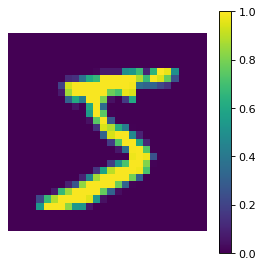

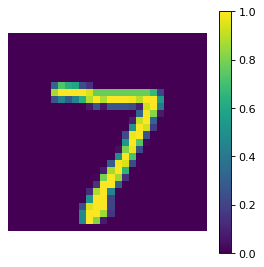

In [7]:
show_image(data_train[0])
show_image(data_test[0])

In [8]:
masks = {}
for i in range(10):
    masks[i] = data_train_labels == i
    
masks_test = {}
for i in range(10):
    masks_test[i] = data_test_labels == i

In [9]:
data = {}
for i in range(10):
    data[i] = data_train[masks[i]]
    
data_t = {}
for i in range(10):
    data_t[i] = data_test[masks_test[i]]

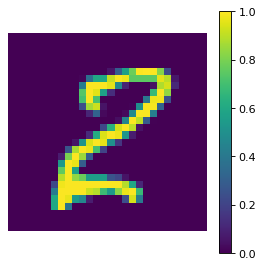

In [10]:
show_image(data[2][383])

# Define Model

In [11]:
from neurons import *

In [24]:
net = Network()
ntype = LIFrate

In [25]:
net.add(Sensory, 'input', 784, transmitter=torch.tensor([1,1,0,0]))
net.add(ntype, 'hidden',1000, transmitter=torch.tensor([1,1,0,0]))

n_feedback = 15
for i in range(10):
    net.add(ntype, f'output{i}', 3, transmitter=torch.tensor([1,0,0,0]))
    net.add(Sensory, f'pos_feedback{i}', n_feedback, transmitter=torch.tensor([0,0,1,0]))
    net.add(Sensory, f'neg_feedback{i}', n_feedback, transmitter=torch.tensor([0,0,0,1]))

In [26]:
net.connect('input', 'hidden')
for i in range(10):
    net.connect('hidden', f'output{i}')
    net.connect(f'pos_feedback{i}', f'output{i}')
    net.connect(f'neg_feedback{i}', f'output{i}')

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

In [28]:
net.compile(device=device)

model successfully compiled.



In [31]:
net.bundles['hidden'].synapses.is_cuda

False

In [30]:
net = torch.load("net")

# Define some functions for plotting

In [32]:
def plot_synapses(synapses, lim=None):
    fig, ax = plt.subplots(figsize=(16,6), dpi=80)
    ax.set_title('Synaptic Weights')
    ax.set_xlabel('Pre-Synaptic Neuron')
    ax.set_ylabel('Post-Synaptic Neuron')
    im = ax.pcolormesh(np.arange(synapses.shape[1]), np.arange(synapses.shape[0]), synapses, shading='nearest', cmap=cmap, norm=Normalize(0, lim))
    fig.colorbar(im, ax=ax)
    plt.show()

In [33]:
def plot_voltage(voltage_history, norm=spike_norm, **kwargs):
    fig, ax = plt.subplots(figsize=(16,6), dpi=80)
    ax.set_title('Membrane Potential')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Neuron #')
    ax.set(**kwargs)
    im = ax.pcolormesh(np.arange(voltage_history.shape[0]) * dt, np.arange(voltage_history.shape[1]), voltage_history.T, shading='nearest', cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax)
    plt.show()

In [34]:
def plot_outputs(output_history, **kwargs):
    fig, ax = plt.subplots(figsize=(16,6), dpi=80)
    ax.set_title('Spikes')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Neuron #')
    ax.set(**kwargs)
    im = ax.pcolormesh(np.arange(output_history.shape[0]) * dt, np.arange(output_history.shape[1]), output_history.T, shading='nearest', cmap='gray_r', norm=Normalize(0,1))
    ax.grid(alpha=0.2)
    fig.colorbar(im, ax=ax, label='firing rate')
    plt.show()

In [35]:
def plot_history_choice(history, choice=0, title=None, **kwargs):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14,8), dpi=80, constrained_layout=True)
    fig.suptitle(title)
    
    ax1.set_title('current')
    ax1.plot(np.arange(history.current.shape[0]) * dt, history.current.T[choice], lw=1)
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('current [mA]')
    ax1.set(**kwargs)
    ax1.grid(alpha=0.2)

    ax2.set_title('membrane potential')
    ax2.plot(np.arange(history.voltage.shape[0]) * dt, history.voltage.T[choice], '-', lw=1)
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('voltage [mV]')
    ax2.set(**kwargs)
    ax2.grid(alpha=0.2)
    
    ax3.set_title('spikes')
    ax3.plot(np.arange(history.outputs[:,:,0].shape[0]) * dt, history.outputs[:,:,0].T[choice], '-', lw=1)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('firing rate')
    ax3.set_ylim(0,1)
    ax3.set(**kwargs)
    ax3.grid(alpha=0.2)

    plt.show()

# Training Simulation

In [36]:
net.bundles['hidden'].synapses.shape

torch.Size([1000, 784, 4])

In [37]:
osh = net.bundles['output0'].synapses.shape
osh

torch.Size([3, 1030, 4])

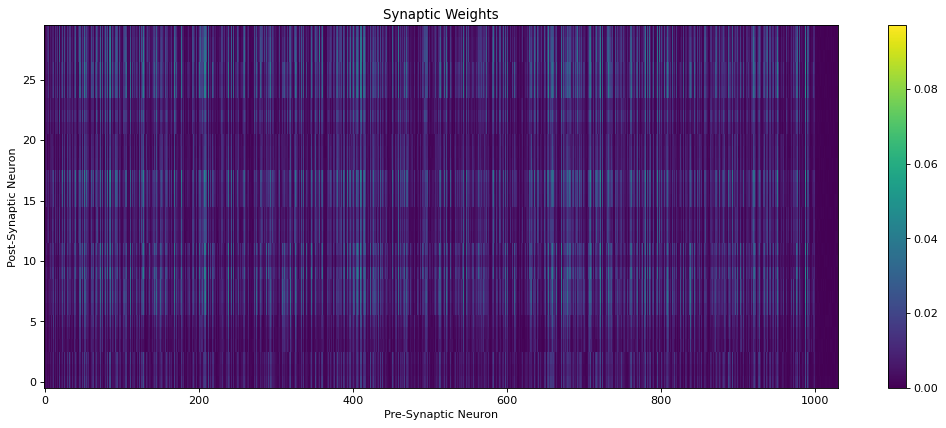

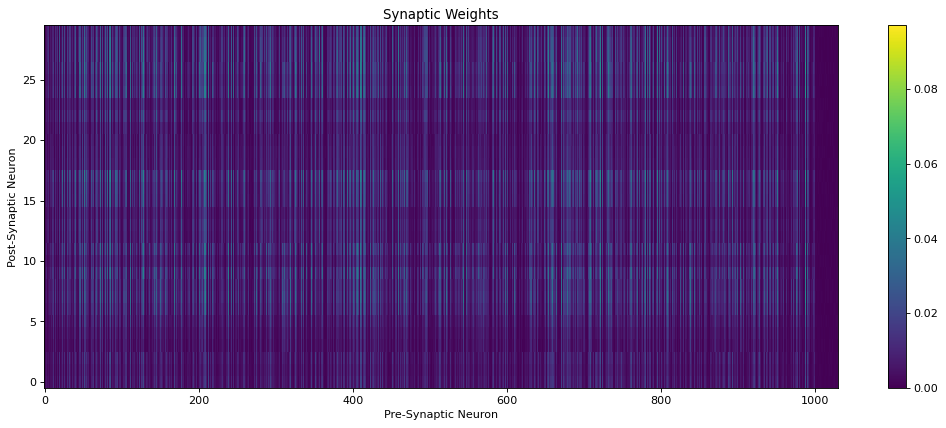

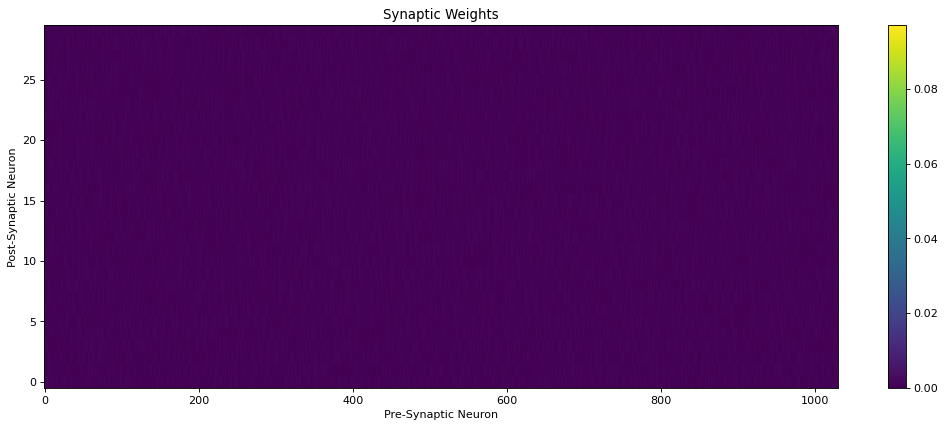

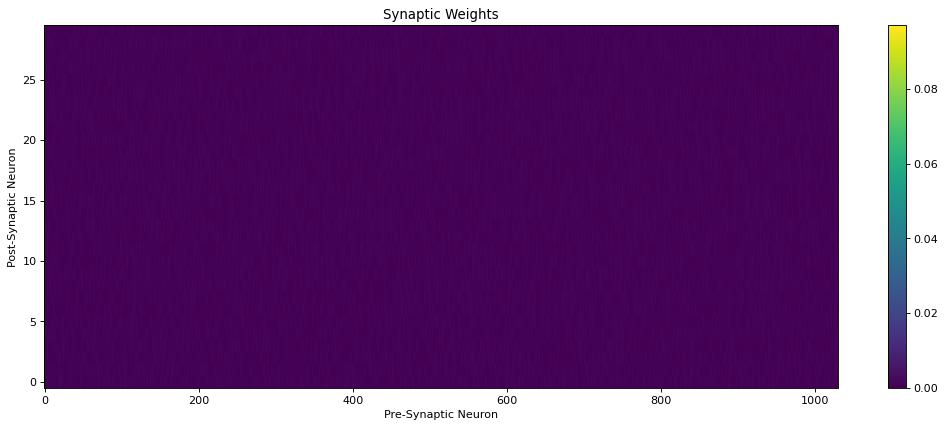

In [38]:
plot_synapses(np.concatenate([
    net.bundles[f'output{i}'].synapses[:,:,0].cpu()
for i in range(10)]), lim=100 / osh[1])
plot_synapses(np.concatenate([
    net.bundles[f'output{i}'].synapses[:,:,1].cpu()
for i in range(10)]), lim=100 / osh[1])
plot_synapses(np.concatenate([
    net.bundles[f'output{i}'].synapses[:,:,2].cpu()
for i in range(10)]), lim=100 / osh[1])
plot_synapses(np.concatenate([
    net.bundles[f'output{i}'].synapses[:,:,3].cpu()
for i in range(10)]), lim=100 / osh[1])

In [39]:
# plot_synapses(net.bundles['hidden'].synapses[:,:,0], lim=0.1)
# plot_synapses(net.bundles['hidden'].synapses[:,:,1], lim=0.1)

In [40]:
# plot_synapses(net.bundles['output0'].synapses[:,:,0], lim=0.1)
# plot_synapses(net.bundles['output0'].synapses[:,:,1], lim=0.1)

In [42]:
net.reset_history()
net.record_history = True
net.train = True

dt = 0.01
n_digits_per_class = 3000
time_per_digit = 1
start = 2000
steps_per_digit = int(time_per_digit / dt)
steps = n_digits_per_class*10*steps_per_digit
total_time = time_per_digit * n_digits_per_class * 10

print(f"total time: {total_time} seconds")
print(f"time_per_digit: {time_per_digit} seconds")
print()
print(f"dt: {dt}")
print(f"total_steps: {steps}")
print(f"steps per digit: {steps_per_digit}")
print()

t_start = time.time()
print("begin simulation...")
for i in range(start, start + n_digits_per_class):
    for j in range(10):
        net.bundles['input'].stim[:] = data[j][i].reshape(-1)
        for k in range(10):
            net.bundles[f'pos_feedback{k}'].stim[:] = torch.tensor([k == j for _ in range(n_feedback)]).to(net.device) * 0.9
            net.bundles[f'neg_feedback{k}'].stim[:] = torch.tensor([k != j for _ in range(n_feedback)]).to(net.device) * 0.9
        for l in range(steps_per_digit):
            net.step(dt)
            print(f'{((i - start)*10*steps_per_digit + j*steps_per_digit + l+1)/steps*100:.2f}%', end='\r')

t_end = time.time() - t_start
print(f'simulation ended. time: {t_end / 60:.1f} minutes')

total time: 30000 seconds
time_per_digit: 1 seconds

dt: 0.01
total_steps: 3000000
steps per digit: 100

begin simulation...
simulation ended. time: 320.4 minutes


# Training Results

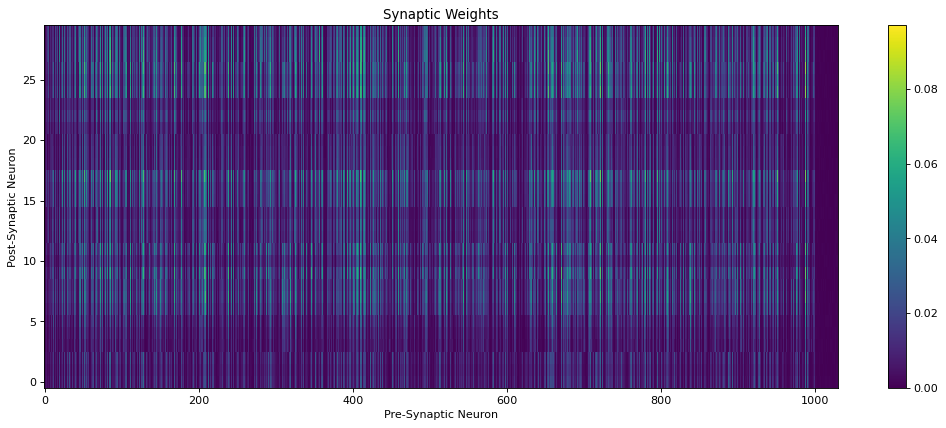

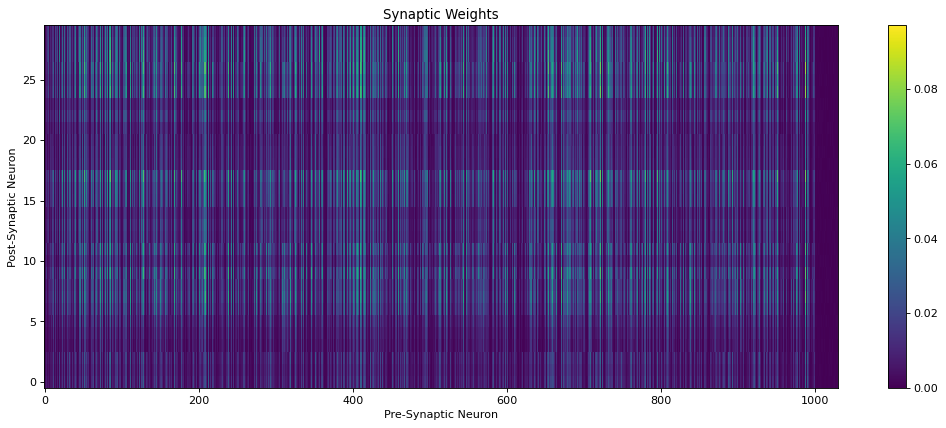

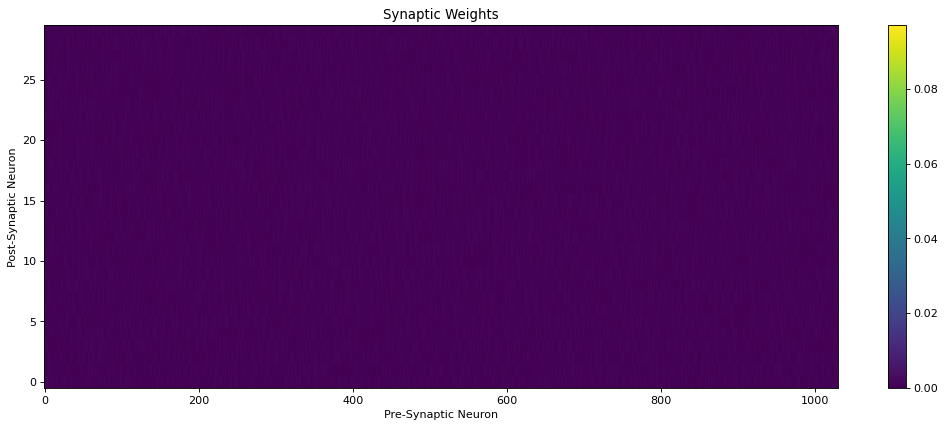

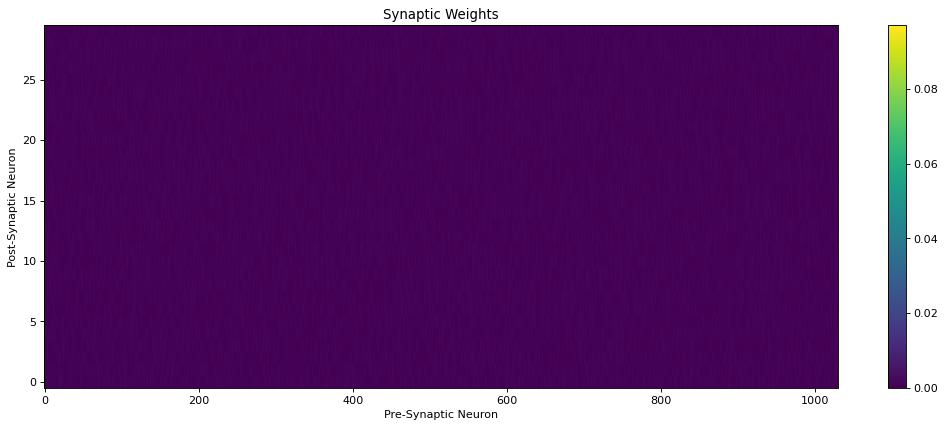

In [59]:
plot_synapses(np.concatenate([
    net.bundles[f'output{i}'].synapses[:,:,0].cpu()
for i in range(10)]), lim=100 / osh[1])
plot_synapses(np.concatenate([
    net.bundles[f'output{i}'].synapses[:,:,1].cpu()
for i in range(10)]), lim=100 / osh[1])
plot_synapses(np.concatenate([
    net.bundles[f'output{i}'].synapses[:,:,2].cpu()
for i in range(10)]), lim=100 / osh[1])
plot_synapses(np.concatenate([
    net.bundles[f'output{i}'].synapses[:,:,3].cpu()
for i in range(10)]), lim=100 / osh[1])

In [44]:
if n_digits_per_class <= 5 and time_per_digit <= 5:
    plot_voltage(net.history['hidden'].voltage, norm=spike_norm)
    plot_outputs(net.history['hidden'].outputs[:,:,0])

In [45]:
if n_digits_per_class <= 20 and time_per_digit <= 20:
    output_voltage = np.concatenate([
        net.history[f'output{i}'].voltage
    for i in range(10)], axis=1)

    output_outputs = np.concatenate([
        net.history[f'output{i}'].outputs[:,:,0]
    for i in range(10)], axis=1)

    plot_voltage(output_voltage, norm=spike_norm)
    plot_outputs(output_outputs)

In [46]:
bundle = net.bundles['output9']
print(currents := torch.einsum('ijk,jk->ik', bundle.synapses, bundle.inputs))
print(currents[:,0] - currents[:,1])
bundle.activation(0.02 * bundle.R * (currents[:,0] - currents[:,1]), device=net.device)

tensor([[6.9557e+00, 6.9080e+00, 7.3799e-03, 0.0000e+00],
        [6.2656e+00, 6.2322e+00, 6.2073e-03, 0.0000e+00],
        [5.7499e+00, 5.7051e+00, 5.7688e-03, 0.0000e+00]])
tensor([0.0478, 0.0334, 0.0448])


tensor([0.0668, 0.0338, 0.0591])

In [47]:
if n_digits_per_class <= 20 and time_per_digit <= 20:
    for i in range(10):
        plot_history_choice(net.history[f'output{i}'], choice=1, title=f'output neuron {i}')

In [48]:
# raise

# Evaluation

In [49]:
steps = 1000
net.bundles['input'].outputs[:] = 0

for i in range(steps):
    net.step(dt)
    print(f'{(i+1)/steps*100:.2f}%', end='\r')

In [57]:
net.train = False
net.reset_history()
net.record_history = True

n_digits_per_class = 100
time_per_digit = 1
start = 0

steps_per_digit = int(time_per_digit / dt)
steps = n_digits_per_class*10*steps_per_digit
time_total = time_per_digit * n_digits_per_class * 10

print(f"total time: {time_total} seconds")
print(f"time_per_digit: {time_per_digit} seconds")
print()
print(f"dt: {dt}")
print(f"total_steps: {steps}")
print(f"steps per digit: {steps_per_digit}")
print()

for k in range(10):
    net.bundles[f'pos_feedback{k}'].stim[:] = 0
    net.bundles[f'neg_feedback{k}'].stim[:] = 0

predictions = []
print("begin simulation...")
for i in range(start, start + n_digits_per_class):
    for j in range(10):
        net.bundles['input'].stim[:] = data_t[j][i].reshape(-1)
        for k in range(steps_per_digit):
            net.step(dt)
            print(f'{((i - start)*10*steps_per_digit + j*steps_per_digit + k+1)/steps*100:.2f}%', end='\r')
        predictions.append(np.argmax([torch.mean(net.bundles[f'output{i}'].outputs[:,0]).cpu() for i in range(10)]))
            
print('simulation ended.')

total time: 1000 seconds
time_per_digit: 1 seconds

dt: 0.01
total_steps: 100000
steps per digit: 100

begin simulation...
simulation ended.


In [58]:
print(predictions)
score = np.arange(len(predictions)) % 10 == predictions
print("score:", score.mean())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 2, 6, 5, 0, 7, 8, 9, 0, 1, 7, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 3, 4, 5, 6, 7, 9, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 3, 4, 5, 6, 0, 8, 9, 0, 1, 2, 5, 4, 5, 6, 9, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 0, 9, 0, 1, 2, 3, 4, 5, 6, 4, 8, 9, 0, 1, 2, 3, 4, 5, 6, 2, 5, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 0, 1, 2, 3, 4, 5, 5, 7, 5, 9, 0, 1, 2, 3, 4, 5, 0, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 5, 4, 5, 4, 7, 8, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 4, 0, 9, 0, 1, 3, 3, 4, 5, 0, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 0, 9, 0, 1, 2, 3, 0, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 3, 6, 7, 8, 9, 0, 1, 2, 

In [52]:
if n_digits_per_class <= 1 and time_per_digit <= 1:
    plot_voltage(net.history['hidden'].voltage, norm=spike_norm)
    plot_outputs(net.history['hidden'].outputs[:,:,0])

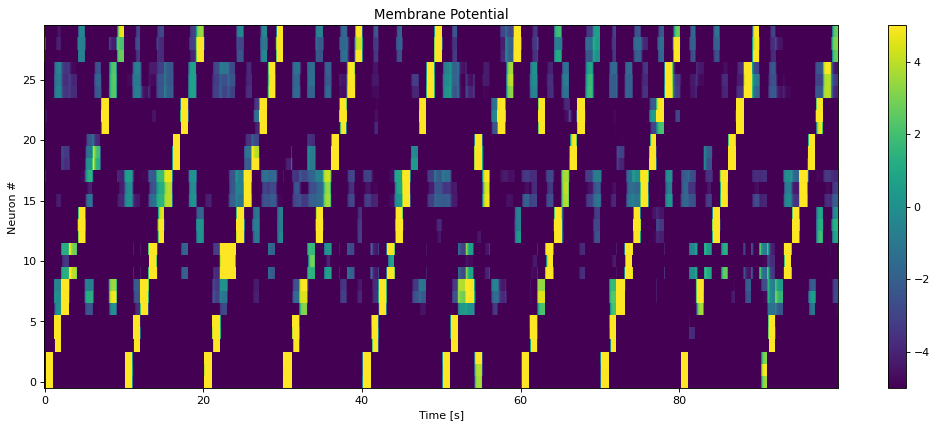

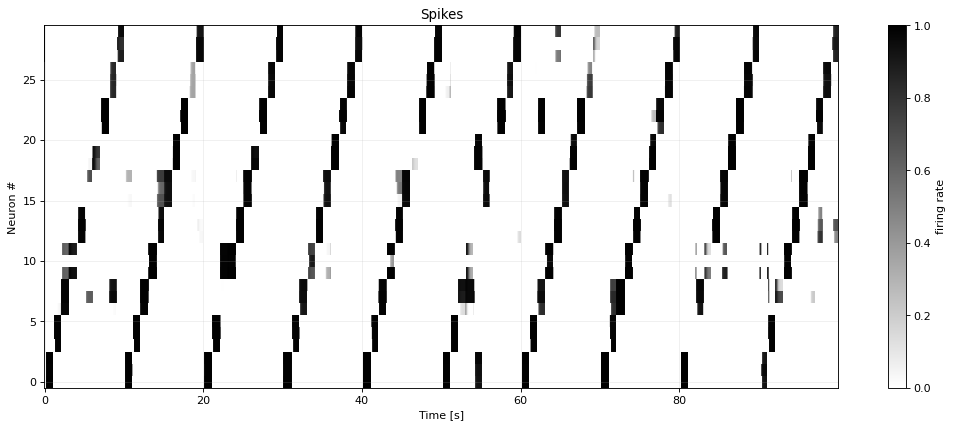

In [53]:
if n_digits_per_class <= 10 and time_per_digit <= 10:
    output_voltage = np.concatenate([
        net.history[f'output{i}'].voltage
    for i in range(10)], axis=1)
    
    output_outputs = np.concatenate([
        net.history[f'output{i}'].outputs[:,:,0]
    for i in range(10)], axis=1)
    
    plot_voltage(output_voltage, norm=spike_norm)
    plot_outputs(output_outputs)

In [54]:
bundle = net.bundles['output0']
print(currents := torch.einsum('ijk,jk->ik', bundle.synapses, bundle.inputs))
bundle.activation(bundle.delta * bundle.R * currents[:,3], device=net.device)

tensor([[2.0660, 2.1518, 0.0000, 0.0000],
        [1.7580, 1.8297, 0.0000, 0.0000],
        [2.0331, 2.1183, 0.0000, 0.0000]])


tensor([0., 0., 0.])

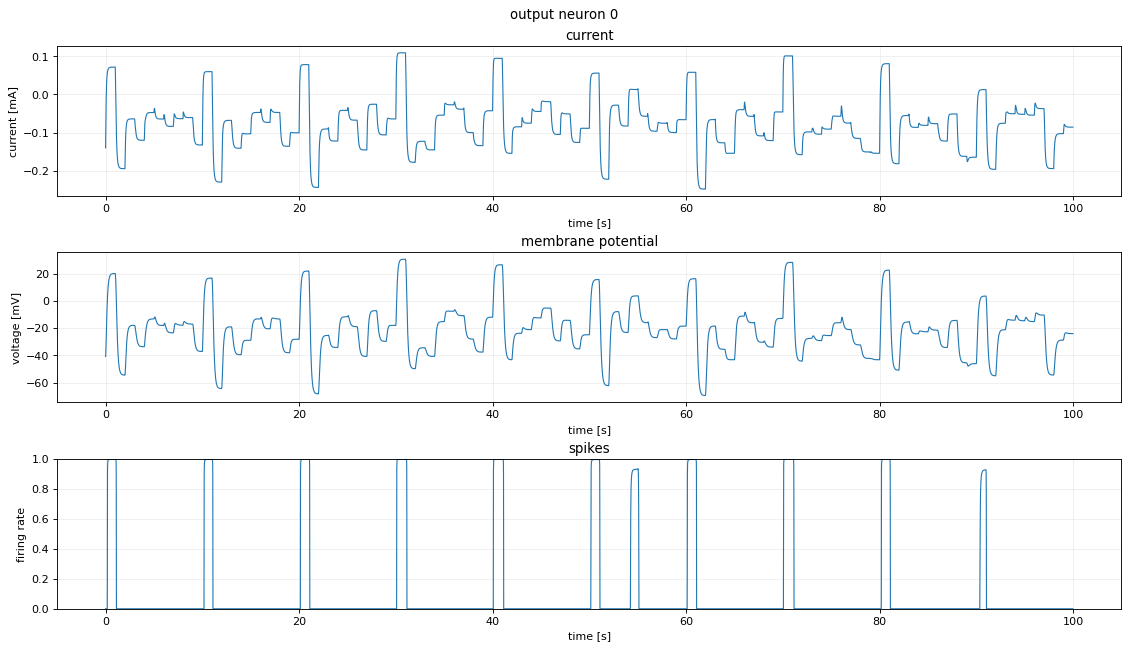

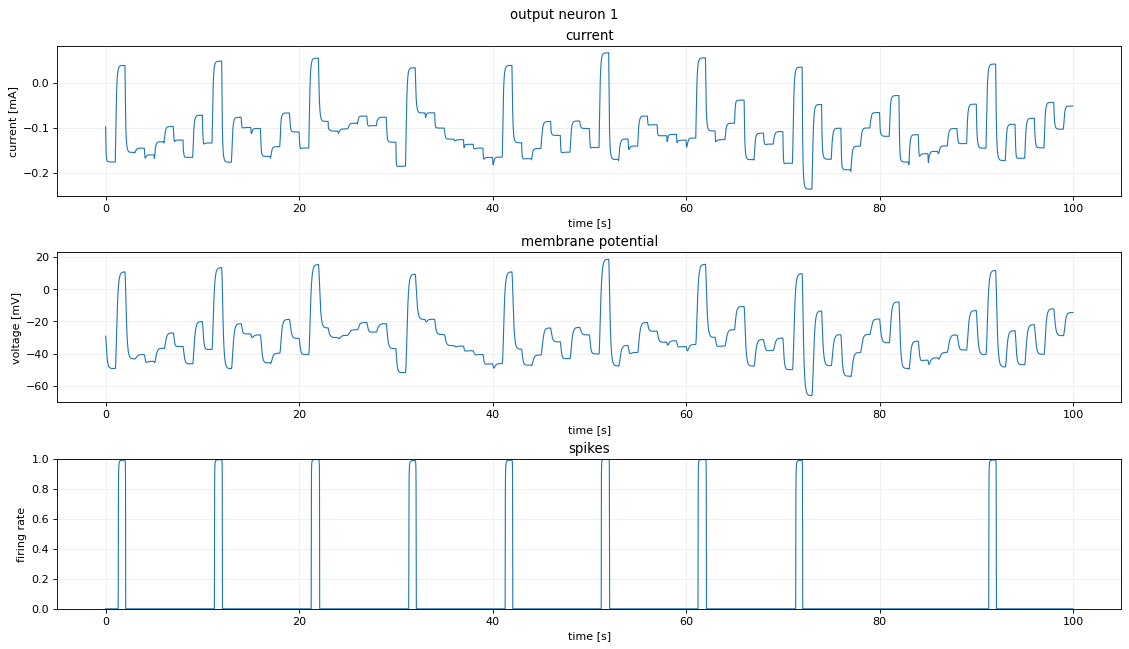

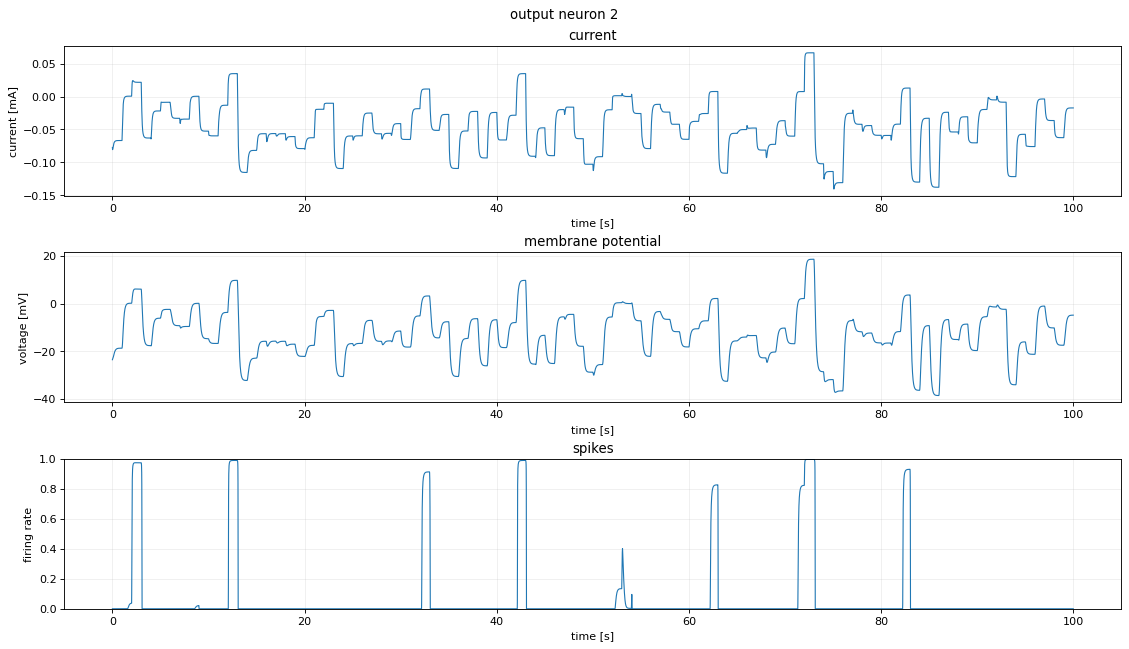

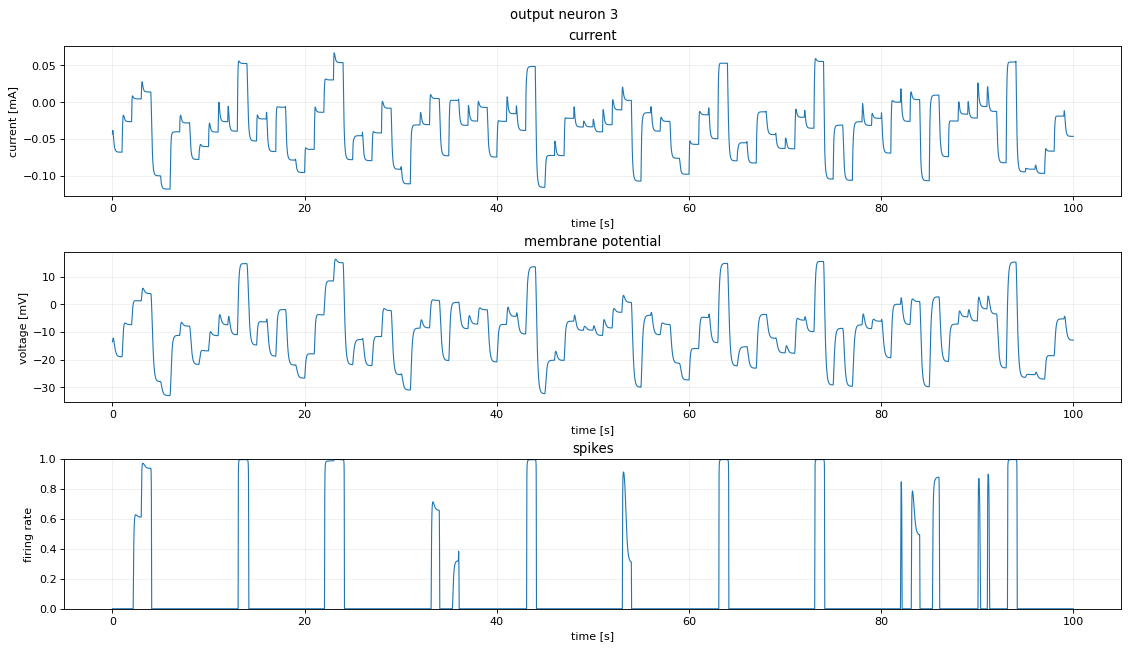

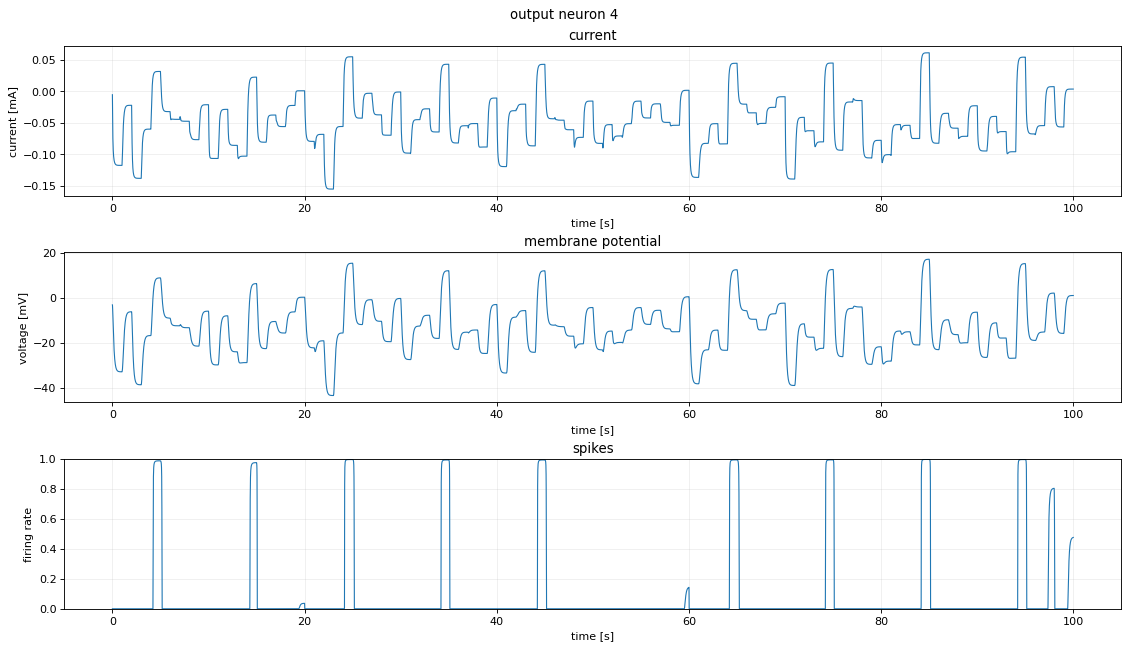

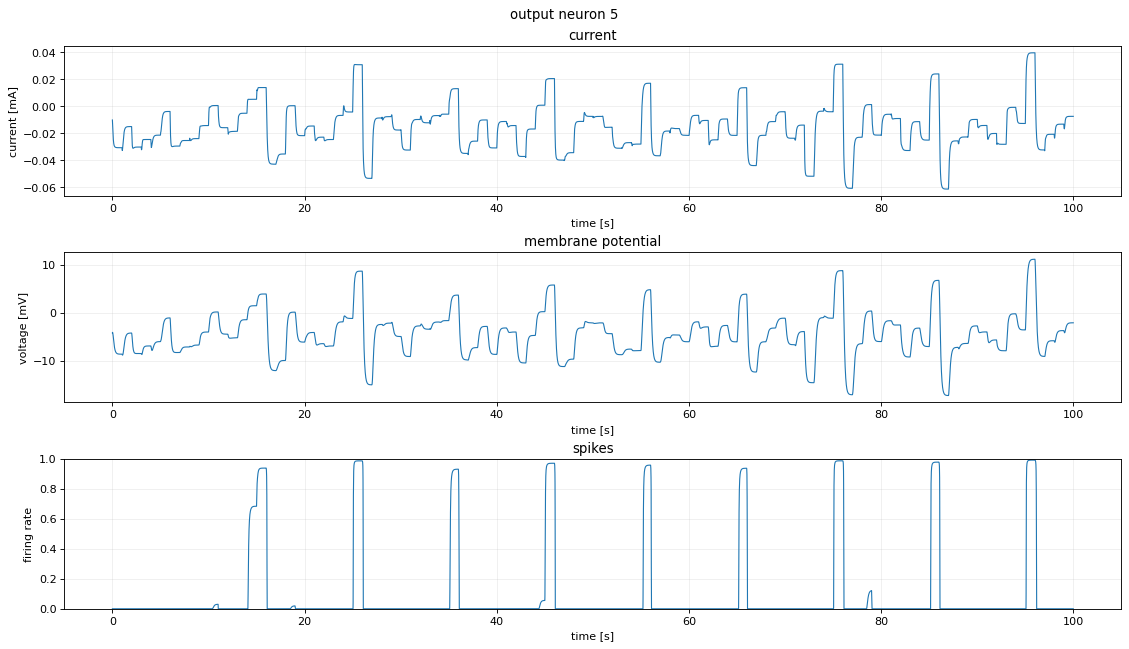

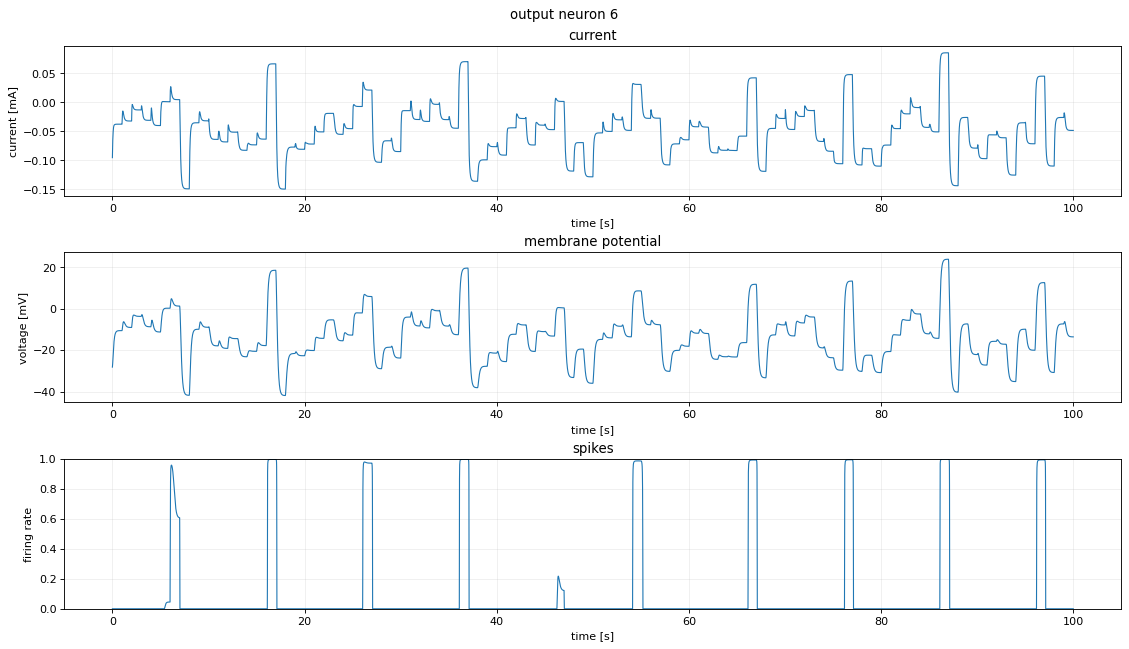

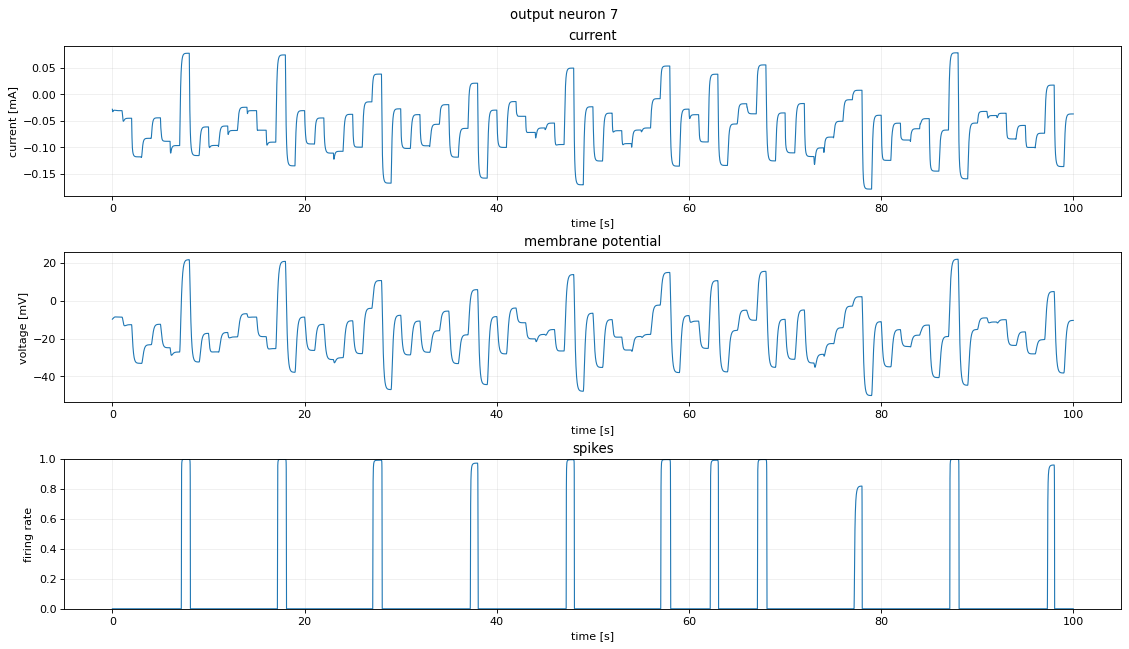

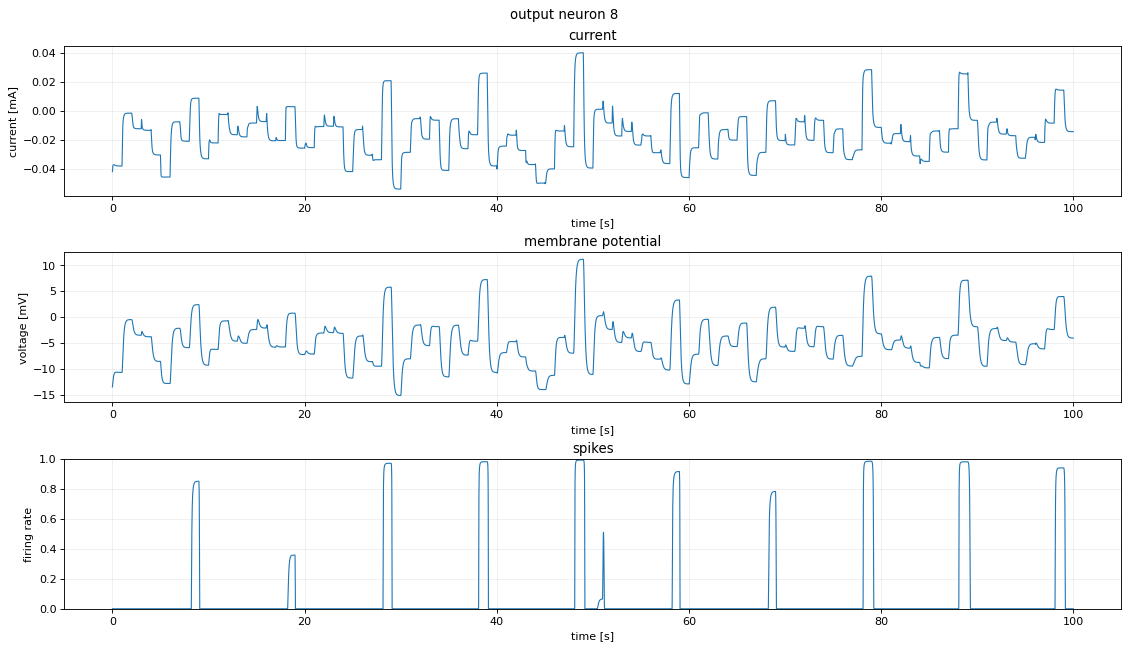

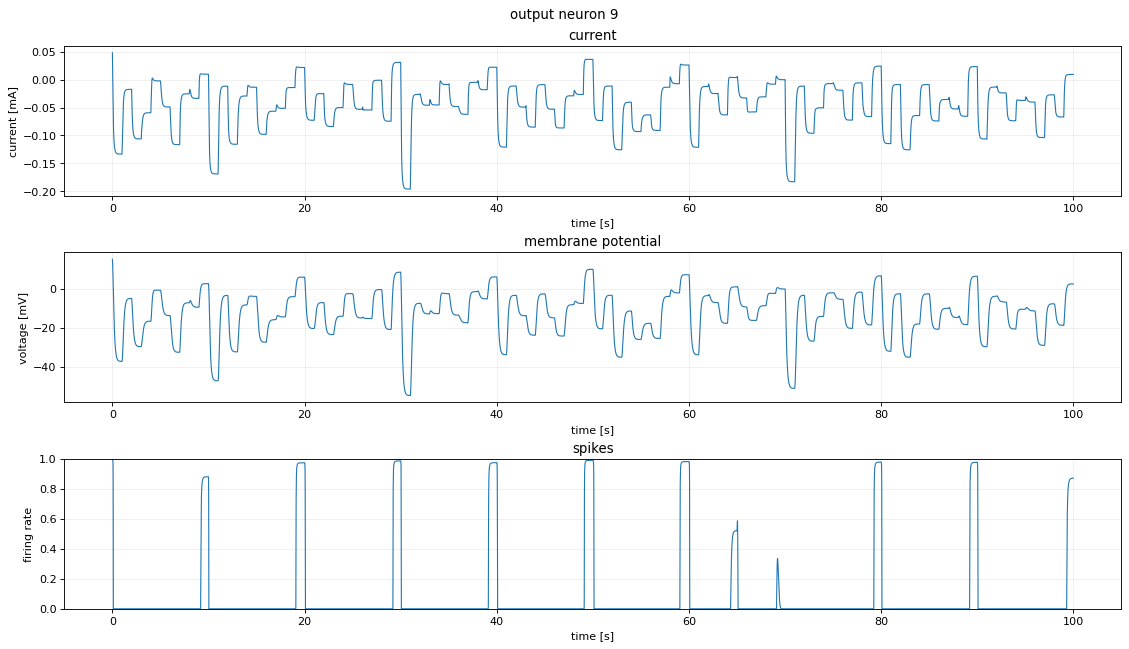

In [55]:
for i in range(10):
    plot_history_choice(net.history[f'output{i}'], choice=0, title=f'output neuron {i}')

In [56]:
torch.save(net, "net")